In [1]:
%matplotlib inline
import numpy as np
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
from matplotlib.dates import epoch2num
changed_order_prices = np.genfromtxt('/tmp/changed_order_prices.csv', delimiter=',')
new_order_counts = np.genfromtxt('/tmp/new_order_counts.csv', delimiter=',')
new_order_prices = np.genfromtxt('/tmp/new_order_prices.csv', delimiter=',')
new_order_volumes = np.genfromtxt('/tmp/new_order_volumes.csv', delimiter=',')
sold_volumes = np.genfromtxt('/tmp/sold_volumes.csv', delimiter=',')
total_volumes = np.genfromtxt('/tmp/total_volumes.csv', delimiter=',')
total_new_order_volumes = np.genfromtxt('/tmp/total_new_order_volumes.csv', delimiter=',')
min_sells = np.genfromtxt('/tmp/min_sell.csv', delimiter=',')
max_buys = np.genfromtxt('/tmp/max_buy.csv', delimiter=',')

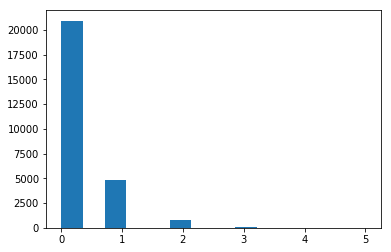

In [2]:
_ = plt.hist(new_order_counts[:,1], bins=14)

In [3]:
np.sum(new_order_counts[np.newaxis,:,1] == np.arange(14)[:,np.newaxis], axis=1)

array([20916,  4819,   793,   121,    30,     6,     0,     0,     0,     0,     0,     0,     0,     0])

In [4]:
def new_order_counts_geometric():
    p = 1.0 / (1.0 + np.mean(new_order_counts[:,1])) # geometric distribution parameter
    print(p)
    (p * (1 - p) ** range(14) * len(new_order_counts[:,1])).astype(int)
new_order_counts_geometric()

0.7941255245067405


In [5]:
class changed_order_prices_precompute:
    def __init__(self):
        self.changed = np.around(changed_order_prices[:,2] - changed_order_prices[:,3], 2) != 0
        # restricting to only jita-local orders does not remove the bump
        #changed = np.logical_and(np.around(changed_order_prices[:,1] - changed_order_prices[:,2], 2) != 0, changed_order_prices[:,3] == -3)
        self.x = np.around((changed_order_prices[:,1] - changed_order_prices[:,2])*100).astype(int)
        self.unique_x = np.unique(self.x)
        self.ix = np.empty(self.x.shape, dtype=int)
        self.changed_counts = np.zeros(self.unique_x.shape)
        self.counts = np.zeros(self.unique_x.shape)
        # we have to loop because x[newaxis] == unique_x[:,newaxis]
        # requires too much memory when there are many unique prices.
        for i, n in enumerate(self.x):
            self.ix[i] = np.where(self.unique_x == n)[0]
            self.counts[self.ix[i]] += 1
            self.changed_counts[self.ix[i]] += int(self.changed[i])
    
    def plot_order_price_change_frequency(self):
        p = self.changed_counts.astype(float) / self.counts.astype(float)
        _ = plt.plot(self.unique_x, p, '.-')
        _ = plt.title('change probability by distance from reference')

changed_order_prices_precomputed = changed_order_prices_precompute()

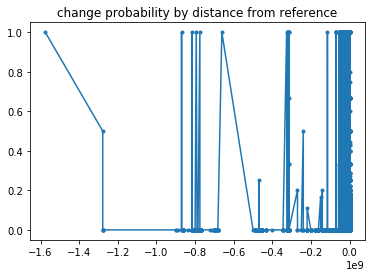

In [6]:
changed_order_prices_precomputed.plot_order_price_change_frequency()

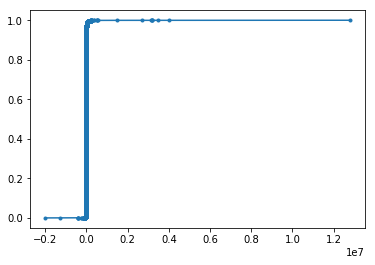

In [7]:
def plot_dist_diff_changed_vs_ref():
    x = changed_order_prices[changed_order_prices_precomputed.changed,3] - changed_order_prices[changed_order_prices_precomputed.changed,1]
    _ = plt.plot(sorted(x), np.arange(len(x), dtype=float) / len(x), '.-')

plot_dist_diff_changed_vs_ref()

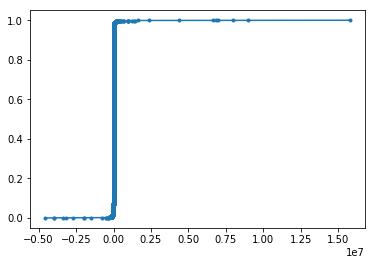

In [29]:
def plot_dist_diff_new_vs_ref():
    x = new_order_prices[:,2] - new_order_prices[:,1]
    _ = plt.plot(sorted(x), np.arange(len(x), dtype=float) / len(x), '.-')
plot_dist_diff_new_vs_ref()

l = 0.09287392325763509
zeros: 3681
neg. loglikelihood(lambda=0.09287392325763509): 90102.23257927797


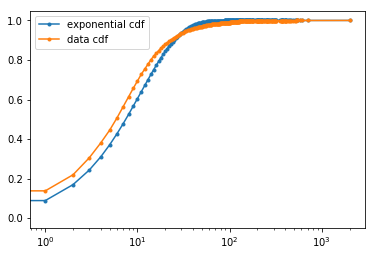

In [9]:
def sold_volumes_exponential():
    N = len(sold_volumes[:,1])
    mean = np.mean(sold_volumes[:,1])
    l = 1.0 / mean
    print('l = {}'.format(l))
    #r = 10**np.arange(10)
    #r = np.arange(10)
    r = np.unique(sold_volumes[:,1])
    #r = r[r < 100]
    _ = plt.semilogx(r, 1 - np.exp(-l * r), '.-', label='exponential cdf')
    _ = plt.semilogx(r, np.sum(sold_volumes[np.newaxis,:,1] < r[:,np.newaxis], axis=1).astype(float) / len(sold_volumes[:,1]), '.-', label='data cdf')
    _ = plt.legend()
    print('zeros: {}'.format(np.sum(sold_volumes[:,1] == 0)))
    print('neg. loglikelihood(lambda={}): {}'.format(l, -N*np.log(l)+l*N*mean))
sold_volumes_exponential()

l2 = 0.08006264682850431


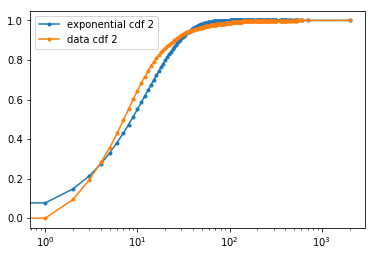

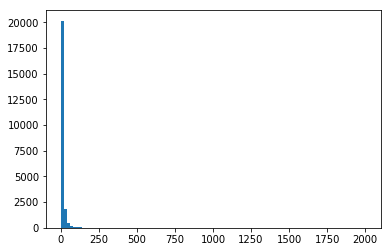

In [10]:
def sold_volumes_exponential_nonzero():
    r = np.unique(sold_volumes[:,1])
    nonzero_sold_volumes = sold_volumes[sold_volumes[:,1] != 0,1]
    l2 = 1.0 / np.mean(nonzero_sold_volumes)
    print('l2 = {}'.format(l2))
    _ = plt.semilogx(r, 1 - np.exp(-l2 * r), '.-', label='exponential cdf 2')
    _ = plt.semilogx(r, np.sum(nonzero_sold_volumes[np.newaxis] < r[:,np.newaxis], axis=1).astype(float) / len(nonzero_sold_volumes), '.-', label='data cdf 2')
    _ = plt.legend()
    _ = plt.figure()
    _ = plt.hist(nonzero_sold_volumes, bins=100)

sold_volumes_exponential_nonzero()

l3 = 0.1061448541645928


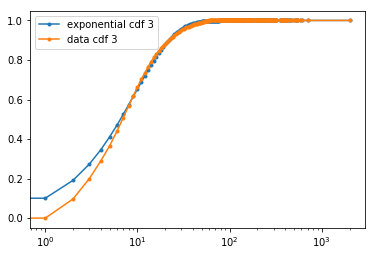

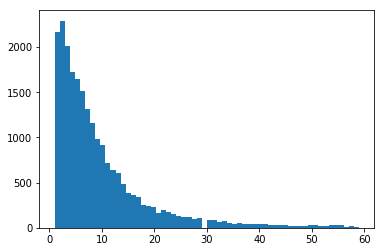

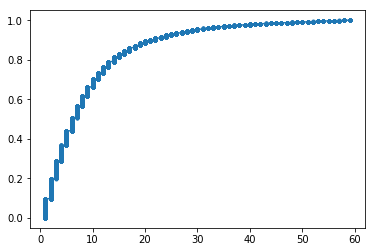

In [11]:
def sold_volumes_exponential_nonzero_small(limit):
    r = np.unique(sold_volumes[:,1])
    nonzero_sold_volumes = sold_volumes[sold_volumes[:,1] != 0,1]
    nonzero_small_sold_volumes = nonzero_sold_volumes[nonzero_sold_volumes < limit]
    l3 = 1.0 / np.mean(nonzero_small_sold_volumes)
    print('l3 = {}'.format(l3))
    _ = plt.semilogx(r, 1 - np.exp(-l3 * r), '.-', label='exponential cdf 3')
    _ = plt.semilogx(r, np.sum(nonzero_small_sold_volumes[np.newaxis] < r[:,np.newaxis], axis=1).astype(float) / len(nonzero_small_sold_volumes), '.-', label='data cdf 3')
    _ = plt.legend()
    _ = plt.figure()
    _ = plt.hist(nonzero_small_sold_volumes, bins=limit)
    _ = plt.figure()
    _ = plt.plot(sorted(nonzero_small_sold_volumes), np.arange(len(nonzero_small_sold_volumes), dtype=float) / len(nonzero_small_sold_volumes), '.-')

sold_volumes_exponential_nonzero_small(limit=60)

l3 = 0.12359390776319346


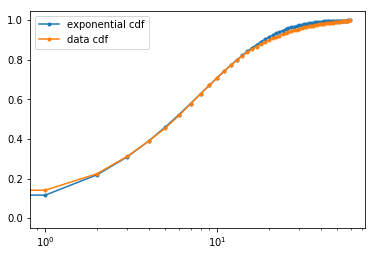

In [12]:
def sold_volumes_exponential_small(limit):
    small_sold_volumes = sold_volumes[sold_volumes[:,1] < limit,1]
    r = np.unique(small_sold_volumes)
    mean = np.mean(small_sold_volumes)
    l3 = 1.0 / mean
    print('l3 = {}'.format(l3))
    _ = plt.semilogx(r, 1 - np.exp(-l3 * r), '.-', label='exponential cdf')
    _ = plt.semilogx(r, np.sum(small_sold_volumes[np.newaxis] < r[:,np.newaxis], axis=1).astype(float) / len(small_sold_volumes), '.-', label='data cdf')
    #_ = plt.loglog(r, np.exp(-l3 * r), '.-', label='exponential cdf')
    #_ = plt.loglog(r, 1-(np.sum(small_sold_volumes[np.newaxis] < r[:,np.newaxis], axis=1).astype(float) / len(small_sold_volumes)), '.-', label='data cdf')
    _ = plt.legend()
    N = len(small_sold_volumes)
sold_volumes_exponential_small(limit=60)

neg. loglikelihood(lambda=0.09287392325763509): 90102.23257927797
neg. loglikelihood(lambda=0.12359390776319346): 91303.39070825696


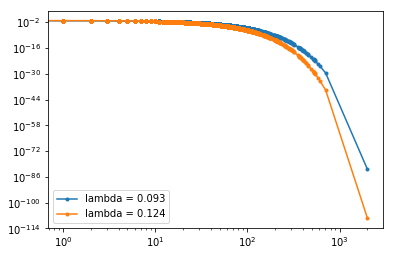

In [13]:
def sold_volumes_exp_compare_tails():
    x = np.sort(sold_volumes[:,1])
    mean = np.mean(x)
    N = len(x)
    l3 = 0.09287392325763509
    l4 = 0.12359390776319346
    _ = plt.loglog(x, l3 * np.exp(-l3 * x), '.-', label='lambda = 0.093')
    _ = plt.loglog(x, l4 * np.exp(-l4 * x), '.-', label='lambda = 0.124')
    #_ = plt.semilogy(-np.log(l3) + l3 * x, '.-', label='lambda = 0.093')
    #_ = plt.semilogy(-np.log(l4) + l4 * x, '.-', label='lambda = 0.124')
    _ = plt.legend()
    print('neg. loglikelihood(lambda={}): {}'.format(l3, -N*np.log(l3)+l3*N*mean))
    print('neg. loglikelihood(lambda={}): {}'.format(l4, -N*np.log(l4)+l4*N*mean))
sold_volumes_exp_compare_tails()

N = 26685
mean = 10.903848229342326
log_mean = 2.389115775491635
mean_log = 1.6137580410066616
s = 0.7753577344849731
k = 0.7607522200229976
theta = 14.332982464399121
alpha = 0.7607522200229976
beta = 0.06976914975538713
neg. loglikelihood: 89772.14551052522


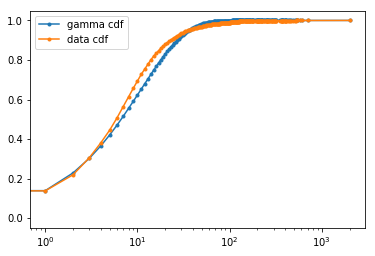

In [14]:
from scipy.special import gamma, gdtr, gdtrc

# https://en.wikipedia.org/wiki/Gamma_distribution#Maximum_likelihood_estimation

def sold_volumes_gamma(nonzero_small_sold_volumes):
    nonzero_small_sold_volumes = np.copy(nonzero_small_sold_volumes)
    nonzero_small_sold_volumes[nonzero_small_sold_volumes == 0] = 0.99
    #zero_cnt = sum(nonzero_small_sold_volumes == 0)
    #nonzero_cnt = len(nonzero_small_sold_volumes) - zero_cnt
    #zero_pct = float(zero_cnt) / len(nonzero_small_sold_volumes)
    #nonzero_pct = float(nonzero_cnt) / len(nonzero_small_sold_volumes)
    #nonzero_small_sold_volumes = nonzero_small_sold_volumes[nonzero_small_sold_volumes != 0]
    r = np.unique(sold_volumes[:,1])
    N = len(nonzero_small_sold_volumes)
    eps = 0
    mean = np.mean(eps+nonzero_small_sold_volumes)
    log_mean = np.log(mean)
    mean_log = np.mean(np.log(eps+nonzero_small_sold_volumes))
    s = log_mean - mean_log
    k = (3 - s + np.sqrt((s-3)**2 + 24*s)) / (12*s)
    theta = mean/k
    alpha = k
    beta = 1 / theta
    #print('zero_cnt = {}'.format(zero_cnt))
    #print('nonzero_cnt = {}'.format(nonzero_cnt))
    #print('zero_pct = {}'.format(zero_pct))
    #print('nonzero_pct = {}'.format(nonzero_pct))
    print('N = {}'.format(N))
    print('mean = {}'.format(mean))
    print('log_mean = {}'.format(log_mean))
    print('mean_log = {}'.format(mean_log))
    print('s = {}'.format(s))
    print('k = {}'.format(k))
    print('theta = {}'.format(theta))
    print('alpha = {}'.format(alpha))
    print('beta = {}'.format(beta))
    _ = plt.semilogx(r, gdtr(beta, alpha, r), '.-', label='gamma cdf')
    _ = plt.semilogx(r, np.sum(nonzero_small_sold_volumes[np.newaxis] < r[:,np.newaxis], axis=1).astype(float) / N, '.-', label='data cdf')
    #_ = plt.loglog(r, gdtrc(beta, alpha, eps+r), '.-', label='gamma cdf')
    #_ = plt.loglog(r, 1-(np.sum(nonzero_small_sold_volumes[np.newaxis] < r[:,np.newaxis], axis=1).astype(float) / N), '.-', label='data cdf')
    _ = plt.legend()
    print('neg. loglikelihood: {}'.format(-((k-1)*np.sum(np.log(eps+nonzero_small_sold_volumes))-N*k-N*k*np.log(theta)-N*np.log(gamma(k)))))
    #print('neg. loglikelihood: {}'.format(-(zero_cnt * np.log(zero_pct))-(nonzero_cnt * np.log(nonzero_pct))-((k-1)*np.sum(np.log(eps+nonzero_small_sold_volumes))-N*k-N*k*np.log(theta)-N*np.log(gamma(k)))))

sold_volumes_gamma(sold_volumes[:,1])

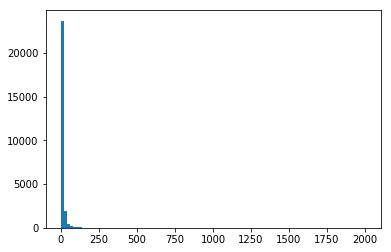

In [15]:
_ = plt.hist(sold_volumes[:,1], bins=100)

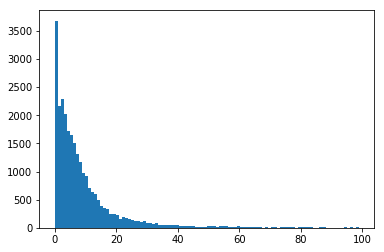

In [16]:
_ = plt.hist(sold_volumes[sold_volumes[:,1] < 100,1], bins=100)

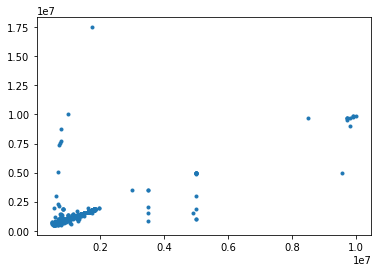

In [17]:
_ = plt.plot(new_order_prices[:,1], new_order_prices[:,2], '.')

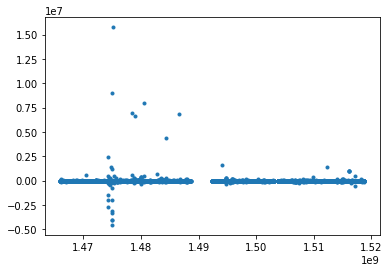

In [18]:
_ = plt.plot(new_order_prices[:,0], new_order_prices[:,2] - new_order_prices[:,1], '.')

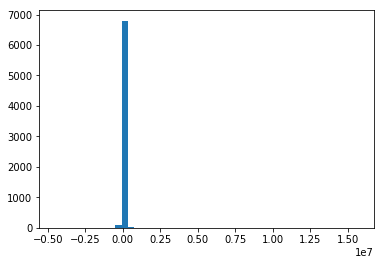

In [19]:
_ = plt.hist(new_order_prices[:,2] - new_order_prices[:,1], bins=50)

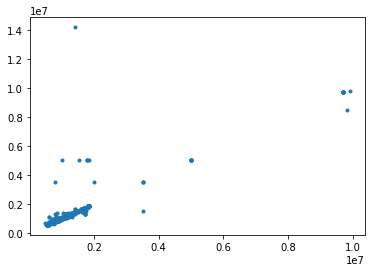

In [20]:
_ = plt.plot(changed_order_prices[changed_order_prices_precomputed.changed,1], changed_order_prices[changed_order_prices_precomputed.changed,3], '.')

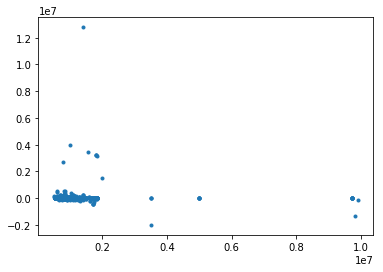

In [21]:
_ = plt.plot(changed_order_prices[changed_order_prices_precomputed.changed,1], changed_order_prices[changed_order_prices_precomputed.changed,3] - changed_order_prices[changed_order_prices_precomputed.changed,1], '.')

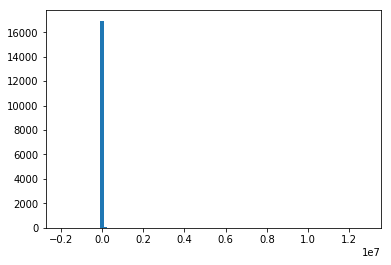

In [22]:
_ = plt.hist(changed_order_prices[changed_order_prices_precomputed.changed,3] - changed_order_prices[changed_order_prices_precomputed.changed,1], bins=100)

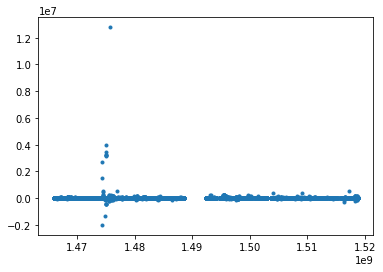

In [23]:
_ = plt.plot(changed_order_prices[changed_order_prices_precomputed.changed,0], changed_order_prices[changed_order_prices_precomputed.changed,3] - changed_order_prices[changed_order_prices_precomputed.changed,1], '.')

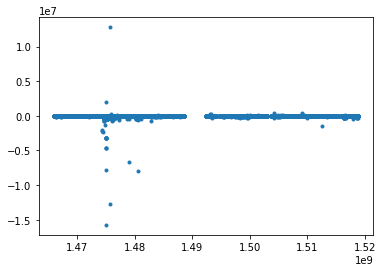

In [24]:
_ = plt.plot(changed_order_prices[changed_order_prices_precomputed.changed,0], changed_order_prices[changed_order_prices_precomputed.changed,3] - changed_order_prices[changed_order_prices_precomputed.changed,2], '.')

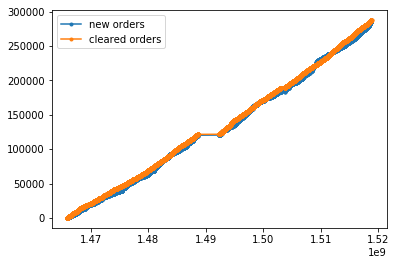

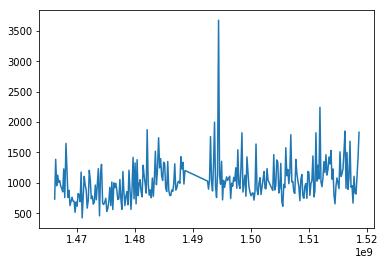

In [25]:
def plot_acc_new_and_cleared():
    t = new_order_volumes[:,0]
    unique_t_new = np.unique(t)
    mask = t[:,np.newaxis] == unique_t_new[np.newaxis]
    v = np.zeros(mask.shape)
    v[mask] = new_order_volumes[:,1]
    v_new = np.cumsum(np.sum(v, axis=0))

    _ = plt.plot(unique_t_new, v_new, '.-', label='new orders')
    _ = plt.plot(sold_volumes[:,0], np.cumsum(sold_volumes[:,1]), '.-', label='cleared orders')
    _ = plt.legend()
    
    _ = plt.figure()
    w = 96
    plt.plot(sold_volumes[:-(sold_volumes.shape[0]%w),0].reshape(-1, w).max(axis=1), sold_volumes[:-(sold_volumes.shape[0]%w),1].reshape(-1, w).sum(axis=1))

plot_acc_new_and_cleared()

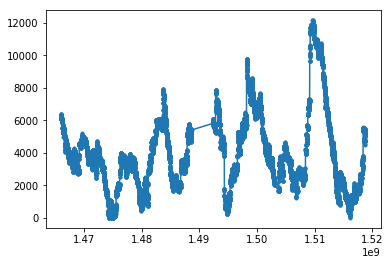

In [26]:
_ = plt.plot(total_volumes[:,0], total_volumes[:,1], '.-')

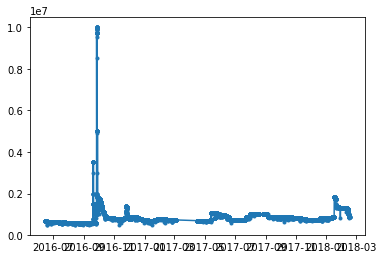

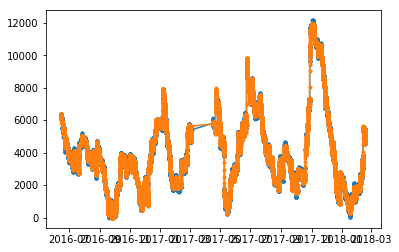

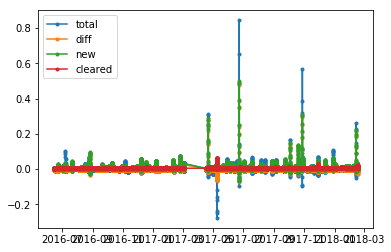

In [27]:
def foo():
    w = 48
    k = 100
    t = sold_volumes[:,0]
    assert np.all(t == total_new_order_volumes[:,0])
    assert np.all(t == total_volumes[:,0])
    x = UnivariateSpline(sold_volumes[:,0], np.cumsum(sold_volumes[:,1]), np.full_like(sold_volumes[:,1], 1.0/k))
    y = UnivariateSpline(total_new_order_volumes[:,0], np.cumsum(total_new_order_volumes[:,1]), np.full_like(total_new_order_volumes[:,1], 1.0/k))
    z = UnivariateSpline(total_volumes[:,0], total_volumes[:,1], np.full_like(total_volumes[:,1], 1.0/k))
    
    _ = plt.plot_date(epoch2num(min_sells[:,0]), min_sells[:,1], '.-')
    plt.figure()
    _ = plt.plot_date(epoch2num(total_volumes[:,0]), total_volumes[:,1], '.-', label='data')
    _ = plt.plot_date(epoch2num(t), z(t), '.-', label='fit')
    #plt.figure()
    #plt.plot_date(epoch2num(total_new_order_volumes[:-(total_new_order_volumes.shape[0]%w),0].reshape(-1,w).max(axis=1)), total_new_order_volumes[:-(total_new_order_volumes.shape[0]%w),1].reshape(-1,w).sum(axis=1), '.-')
    #plt.plot_date(epoch2num(total_new_order_volumes[:,0]), y(total_new_order_volumes[:,0], 1)*86400.0, label='fit')
    plt.figure()
    plt.plot_date(epoch2num(t), z(t, 1), '.-', label='total')
    plt.plot_date(epoch2num(t), y(t, 1) - x(t, 1), '.-', label='diff')
    plt.plot_date(epoch2num(t), y(t, 1), '.-', label='new')
    plt.plot_date(epoch2num(t), x(t, 1), '.-', label='cleared')
    plt.legend()
    plt.show()

foo()